In [18]:
%cd /home/soda/rcappuzz/work/prepare-data-lakes

/home/soda/rcappuzz/work/prepare-data-lakes


In [17]:
import src.yago.utils as utils

In [19]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import os
import polars.selectors as cs
import random

from sklearn.utils import murmurhash3_32

sns.set_theme("paper", style="whitegrid")

In [20]:
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [21]:
yago_path = Path("/storage/store3/work/jstojano/yago3/")
facts1_path = Path(yago_path, "facts_parquet/yago_updated_2022_part1")
facts2_path = Path(yago_path, "facts_parquet/yago_updated_2022_part2")
fname = "yagoTypes"
yagotypes_path = Path(facts1_path, f"{fname}.tsv.parquet")
df_types = utils.import_from_yago(yagotypes_path)
fname = "yagoFacts"
yagofacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagofacts = utils.import_from_yago(yagofacts_path)
fname = "yagoLiteralFacts"
yagoliteralfacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagoliteralfacts = utils.import_from_yago(yagoliteralfacts_path)
fname = "yagoDateFacts"
yagodatefacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagodatefacts = utils.import_from_yago(yagodatefacts_path)
yagofacts = yagofacts.drop("num_object")
yagodatefacts = (
    yagodatefacts.with_columns(
        pl.col("cat_object")
        .str.split("^^")
        .list.first()
        .str.to_datetime(strict=False)
        .dt.date()
        .cast(pl.Utf8)
        .alias("cat_object")
    )
    .drop_nulls("cat_object")
    .drop("num_object")
)
yagoliteralfacts = yagoliteralfacts.with_columns(
    pl.when(pl.col("num_object").is_not_null())
    .then(pl.col("num_object"))
    .otherwise(pl.col("cat_object"))
    .alias("cat_object")
).drop("num_object")
df_facts = pl.concat([yagofacts, yagoliteralfacts, yagodatefacts]).drop("id")

In [22]:
wikilabels_path = Path(
    yago_path, "facts_parquet/yago_updated_2022_part2/wikipediaLabels.tsv.parquet"
)
wikipedia_labels = utils.import_from_yago(wikilabels_path)

# Full tables

In [23]:
subjects_with_wordnet = (
    df_types.filter(pl.col("cat_object").str.starts_with("<wordnet_"))
    .select(pl.col("subject"), pl.col("cat_object"))
    .rename({"cat_object": "type"})
)
n_groups = len(subjects_with_wordnet.unique("type"))

In [25]:
def clean_string(string_to_clean):
    pattern = re.compile(r"<{1}([a-zA-Z0-9_]+)>{1}")
    m = re.sub(pattern, "\\1", string_to_clean)
    return m

In [26]:
max_fields = 2
dest_path = Path("data/yago3-dl/wordnet_vldb")

In [10]:
for this_type, this_df in tqdm(subjects_with_wordnet.group_by("type"), total=n_groups):
    clean_type = clean_string(this_type)
    joined_df = df_facts.join(this_df.select(pl.col("subject", "type")), on="subject")
    if len(joined_df) == 0:
        continue
    base_df = joined_df.select(pl.col("subject").unique()).lazy()
    for idx, grp in joined_df.group_by(by=["predicate"]):
        this_predicate = clean_string(idx[0])
        grp = (
            grp.group_by("subject")
            .head(max_fields)
            .select(pl.col("subject", "cat_object"))
            .rename({"cat_object": this_predicate})
        )
        try:
            grp = grp.with_columns(pl.col(this_predicate).cast(pl.Float64))
        except pl.ComputeError:
            pass
        grp = grp.lazy()
        base_df = base_df.join(grp, on="subject", how="left")
    base_df = base_df.rename({"subject": clean_type})
    df_name = f"wordnet_vldb-{clean_type}.parquet"
    base_df = base_df.collect()
    if len(base_df) > 0:
        base_df.write_parquet(Path(dest_path, df_name))

100%|██████████| 1015/1015 [01:59<00:00,  8.50it/s]


## Profile base tables

In [8]:
list_stats = []
for path in Path(dest_path).glob("*.parquet"):
    this_df = pl.read_parquet(path)
    rows, cols = this_df.shape
    n_num = this_df.select(cs.numeric()).shape[1]
    c_num = this_df.select(~cs.numeric()).shape[1]

    list_stats.append(
        {
            "rows": rows,
            "cols": cols,
            "n_num": n_num,
            "c_num": c_num,
        }
    )
df_stats = pl.from_dicts(list_stats)

In [14]:
df_stats.select(pl.col("cols").mean().alias("mean"),pl.col("cols").median().alias("median"),)

mean,median
f64,f64
8.195627,6.0


(array([218.,  90., 158.,  65.,  61.,  81.,  12.,  38.,  18.,  17.,  27.,
          7.,  14.,   6.,   4.,  15.,   7.,   8.,   4.,   5.,   3.,   1.,
          4.,   2.,   0.,   1.,   1.,   1.,   0.,   1.]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ,
        17.4, 18.8, 20.2, 21.6, 23. , 24.4, 25.8, 27.2, 28.6, 30. , 31.4,
        32.8, 34.2, 35.6, 37. , 38.4, 39.8, 41.2, 42.6, 44. ]),
 <BarContainer object of 30 artists>)

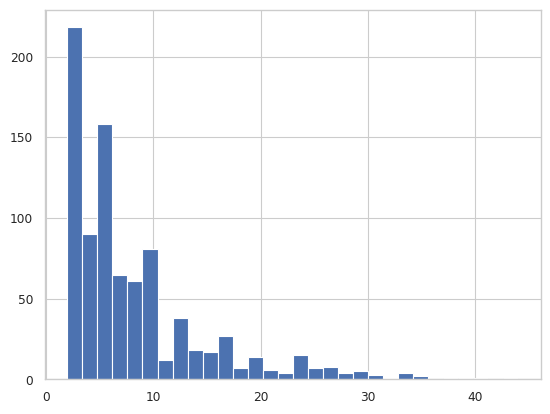

In [11]:
plt.hist(df_stats["cols"], bins=30)

## Build subtables

In [19]:
def generate_table(table, col_comb, subject):
    selected_ = subject + list(col_comb)
    new_df = table.select(selected_).filter(
        pl.any_horizontal(pl.col(col_comb).is_not_null())
    )
    return new_df

In [22]:
def generate_batch(
    target_columns,
    base_table,
    table_name,
    subject,
    case,
    resample=False,
    sample_fraction=0.7,
    min_occurrences=100,
    limit_break=50,
    gen_break=10,
):
    new_dir = Path(base_path, table_name)
    break_counter = 0
    gen_counter = 0
    good_comb = set()
    bad_comb = set()
    while break_counter < limit_break and gen_counter < gen_break:
        comb = random.sample(target_columns, k=random.randint(1, len(target_columns)))
        comb = tuple(comb)
        if (comb not in good_comb) and (comb not in bad_comb):
            table = generate_table(base_table, comb, subject)
            if len(table) > min_occurrences:
                good_comb.add(comb)
                gen_counter += 1
                fname = (
                    table_name
                    + "-"
                    + str(murmurhash3_32("-".join(comb[:])))
                    + case
                    + ".parquet"
                )
                destination_path = Path(new_dir, fname)
                table.write_parquet(destination_path)
                if resample:
                    for sample_counter in range(n_resample):
                        resampled_table = table.sample(fraction=sample_fraction)
                        fname = (
                            table_name
                            + "-"
                            + str(murmurhash3_32("-".join(comb[:])))
                            + "-"
                            + str(sample_counter)
                            + "-"
                            + case
                            + ".parquet"
                        )
                        destination_path = Path(new_dir, fname)
                        resampled_table.write_parquet(destination_path)
            else:
                bad_comb.add(comb)
                break_counter += 1
        else:
            break_counter += 1

In [50]:
base_path = Path("data/yadl/wordnet_vldb")
comb_size = 2
min_occurrences = 50
total_ = sum(1 for _ in base_path.glob("*.parquet"))
limit_break = 100
gen_break = 50
n_resample = 2
sample_fraction = 0.7
resample = False

bc = 0


In [ ]:
for pth in tqdm(base_path.glob("*.parquet"), total=total_):
    table_name = pth.stem

    tgt_table = pl.read_parquet(pth)
    n_rows, n_cols = tgt_table.shape
    n_cols -= 1  # Not counting column `subject`

    subject = [tgt_table.columns[0]]
    target_columns = tgt_table.columns[1:]

    num_columns = tgt_table.select(cs.numeric()).columns
    cat_columns = [_ for _ in tgt_table.select(~cs.numeric()).columns if _ != "subject"]

    if n_rows == 0:
        continue

    new_dir = Path(base_path, table_name)
    os.makedirs(new_dir, exist_ok=True)

    # # All columns
    generate_batch(
        target_columns,
        tgt_table,
        table_name,
        subject,
        "",
        min_occurrences,
        limit_break=limit_break,
        gen_break=gen_break,
    )

    # Numerical columns
    if len(num_columns) >= 2:
        # print(table_name)
        generate_batch(
            num_columns,
            tgt_table,
            subject,
            "num",
            min_occurrences,
            limit_break=limit_break,
            gen_break=gen_break,
        )